- Assess if temperature data can be predicted based on population data (and maybe other external input such as land cover type).

Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
import rasterio as rio
import functions as f
import xarray as xr
from importlib import reload
import os

Reading population data 

Reading temperature data 


Reading land-cover data

In [5]:
#used population data or other data maybe land type, see if we can predict the temperature data.

#load data

folder_path = 'data_UHI'

#load temperature data in data_UHI folder
#iterate over file in folder: 
for file in os.listdir(folder_path):
    filename = os.fsdecode(file)
    if filename.startswith("tas"):
        temp = xr.open_dataset(folder_path + '/' + filename) 
    else: 
        pop = xr.open_dataset(folder_path + '/' + filename)
    

xr.open




ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

In [11]:
reload(f)
croppedPopDay, temp_Lyon_coarsed = f.crop_and_downgrade(pop_day_tiff=pop_day_europe,temp_city=temp_jan_lyon)


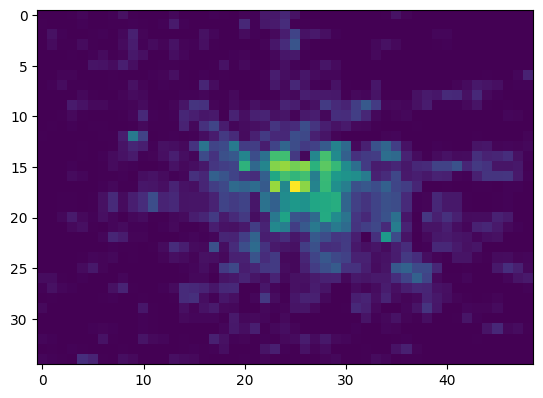

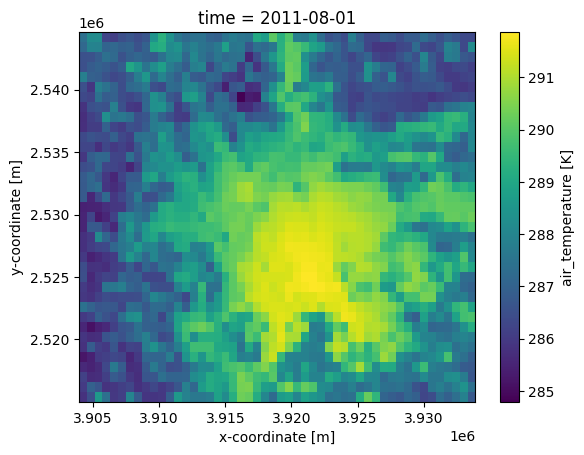

In [39]:
plt.imshow(croppedPopDay)
plt.show()
temp_Lyon_coarsed[0,:,:].plot()

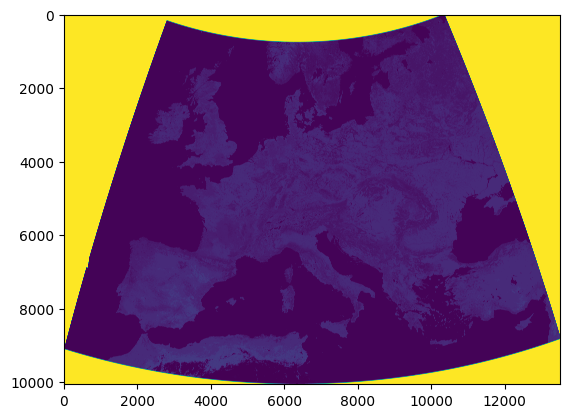

In [22]:
plt.imshow(land_cover.read(1))

In [6]:
dfLyon = pd.read_csv('data_lyon.csv')
dfLyon.drop(['Unnamed: 0'], axis=1, inplace=True)
dfLyon.head()

,Unnamed: 0,temp,month,pop,deltaT,hum,ws
0,0,274.97696,1,1523.592613,2.887176,58.56568,1.229084
1,1,278.47665,1,1416.265328,0.170105,87.76872,2.406370
2,2,271.71550,1,834.930823,0.821411,73.87438,3.112893
3,3,272.90740,1,48.710647,0.649628,78.59554,5.524080
4,4,279.50806,1,470.104484,1.585938,76.02386,2.344400


[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


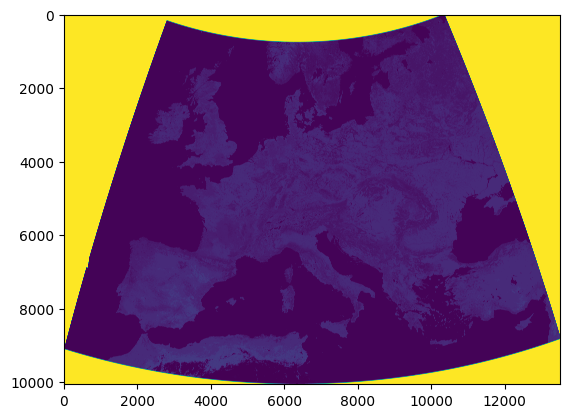

In [4]:
folder_path = 'data_UHI'
pop_day_europe = rio.open(folder_path + '\\ENACT_POP_D012011_EU28_R2020A_4326_30ss_V1_0.tif')
pop_night_europe = rio.open(folder_path + '\\ENACT_POP_N012011_EU28_R2020A_4326_30ss_V1_0.tif')
land_cover = rio.open(folder_path + '\\MCD12Q1.061_LC_Prop1_doy2011001_aid0001_reproj.tif')

city = 'Lyon'
number_of_sample_per_city = 10
#print(land_cover.read(1))
#plt.imshow(land_cover.read(1))

In [5]:
reload(f)
city_df = pd.DataFrame(columns=['temp', 'pop', 'deltaT', 'hour', 'city'])

temp_file_path = folder_path+'/tas_'+city+'_UrbClim_2011_07_v1.0.nc'
rural_mask_file_path = folder_path+'//ruralurbanmask_Lyon_UrbClim_v1.0.nc'
temp_file = xr.open_dataset(temp_file_path)
rural_mask_file = xr.open_dataset(rural_mask_file_path)


cropped_pop_day, cropped_pop_night = f.crop_and_downgrade(pop_day_europe, pop_night_europe, temp_file)

lc_city = f.crop_image(land_cover, temp_file)
print(lc_city)
pop_day_city = f.resample_image(cropped_pop_day, temp_file.tas[0,:,:].shape)
pop_night_city = f.resample_image(cropped_pop_night, temp_file.tas[0,:,:].shape)


lc_city = f.resample_image(lc_city, temp_file.tas[0,:,:].shape)
lc_flatten = np.tile(lc_city.flatten(), temp_file.tas.shape[0])

populations = np.concatenate([np.tile(pop_night_city.flatten(),8), np.tile(pop_day_city.flatten(), 12), np.tile(pop_night_city.flatten(), 4)])
populations = np.tile(populations, 31)

latitude = np.tile(temp_file.latitude.values.flatten(), temp_file.tas.shape[0])
longitude = np.tile(temp_file.longitude.values.flatten(), temp_file.tas.shape[0])

day_hours = np.tile(np.arange(0,24), temp_file.x.shape[0]*temp_file.y.shape[0])
hours = np.tile(day_hours.reshape(temp_file.x.shape[0]*temp_file.y.shape[0], 24).flatten(order='F'), 31)

deltaT = f.compute_deltaT_urban(temp_file, rural_mask_file)
rural = np.tile(rural_mask_file.ruralurbanmask.values.flatten(), temp_file.tas.shape[0])
print(rural.shape, deltaT.shape)
city = np.tile(np.array([city]), number_of_sample_per_city)

#generate random indexes to sample the data
indexes = np.random.randint(0, temp_file.tas.shape[0]*temp_file.tas.shape[1]*temp_file.tas.shape[2], number_of_sample_per_city)
city_df = pd.concat([city_df, pd.DataFrame({'temp': temp_file.tas.values.flatten()[indexes],
                                            'pop':populations[indexes], 
                                            'deltaT': deltaT[indexes],
                                            'hour': hours[indexes],
                                            'isrural' : rural[indexes],
                                            'land cover type':lc_flatten[indexes],
                                            'city' : city,
                                            'latitude' : latitude[indexes],
                                            'longitude' : longitude[indexes]})])

[]


AttributeError: 'Dataset' object has no attribute 'shape'